# ** Importing Libraries**

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef,SCORERS
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from xgboost import XGBClassifier 
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [0]:
from google.colab import files
file=files.upload()

Saving PatientData.csv to PatientData.csv


In [0]:
data=pd.read_csv('PatientData.csv')
data.head()

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,Female,80.0,0,0,0,1,never,25.19
1,Female,54.0,0,0,0,0,NaN,NaN
2,Male,28.0,0,0,0,0,never,NaN
3,Female,36.0,0,0,0,0,current,23.45
4,Male,76.0,0,1,0,1,current,20.14


In [0]:
data.isna().sum()

gender                 0
age                    0
diabetes               0
hypertension           0
stroke                 0
heart disease          0
smoking history    35816
BMI                25444
dtype: int64

In [0]:
data.dtypes

gender              object
age                float64
diabetes             int64
hypertension         int64
stroke               int64
heart disease        int64
smoking history     object
BMI                float64
dtype: object

In [0]:
pandas_profiling.ProfileReport(data)

Number of variables,8
Number of observations,100000
Total Missing (%),7.7%
Total size in memory,6.1 MiB
Average record size in memory,64.0 B
Numeric,2
Categorical,2
Boolean,4
Date,0
Text (Unique),0
Rejected,0


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

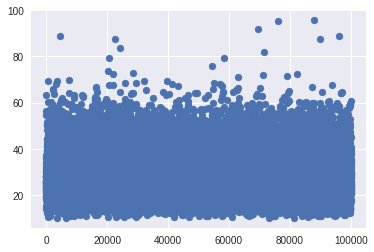

In [0]:
plt.scatter(data.index,data.BMI)

In [0]:
data['smoking history']=data['smoking history'].fillna('Unknown')

In [0]:
data['smoking history'].value_counts()

Unknown        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking history, dtype: int64

In [0]:
train_data_cat=data.select_dtypes(include=[object])
train_data_num=data.select_dtypes(exclude=[object])
train_data_cat=pd.get_dummies(train_data_cat, columns=train_data_cat.columns, drop_first=True)
data_df=pd.concat([train_data_cat,train_data_num],axis=1)

In [0]:
data_df.head()

,gender_Male,gender_Other,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,stroke,heart disease,BMI
0,0,0,0,0,1,0,80.0,0,0,0,1,25.19
1,0,0,0,0,0,0,54.0,0,0,0,0,NaN
2,1,0,0,0,1,0,28.0,0,0,0,0,NaN
3,0,0,0,0,0,0,36.0,0,0,0,0,23.45
4,1,0,0,0,0,0,76.0,0,1,0,1,20.14


In [0]:
from fancyimpute import IterativeImputer

Using TensorFlow backend.


In [0]:
XY_incomplete = data_df.copy()

In [0]:
data_complete_df = pd.DataFrame(IterativeImputer(n_iter=20, sample_posterior=True, random_state=8).fit_transform(XY_incomplete))

In [0]:
data_complete_df.columns=data_df.columns

In [0]:
data_complete_df.head()

,gender_Male,gender_Other,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,stroke,heart disease,BMI
0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,0.0,1.0,25.190000
1,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,19.749781
2,1.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,0.0,0.0,27.503976
3,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,23.450000
4,1.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,1.0,0.0,1.0,20.140000


In [0]:
data_complete_df.shape

(100000, 12)

In [0]:
data_complete_df['diabetes & hypertension']=data_complete_df['diabetes']*data_complete_df['hypertension']
data_complete_df['diabetes & srtoke']=data_complete_df['diabetes']*data_complete_df['stroke']
data_complete_df['diabetes & heart disease']=data_complete_df['diabetes']*data_complete_df['heart disease']
data_complete_df['hypertension & stroke']=data_complete_df['hypertension']*data_complete_df['stroke']
data_complete_df['hypertension & heart disease']=data_complete_df['hypertension']*data_complete_df['heart disease']
data_complete_df['stroke & heart disease']=data_complete_df['stroke']*data_complete_df['heart disease']

In [0]:
data_complete_df['diabetes,hypertension,stroke']=data_complete_df['diabetes']*data_complete_df['hypertension']*data_complete_df['stroke']
data_complete_df['diabetes,hypertension,heart disease']=data_complete_df['diabetes']*data_complete_df['hypertension']*data_complete_df['heart disease']
data_complete_df['hypertension,stroke,heart disease']=data_complete_df['hypertension']*data_complete_df['stroke']*data_complete_df['heart disease']
data_complete_df['diabetes,hypertension,stroke,heart disease']=data_complete_df['diabetes']*data_complete_df['hypertension']*data_complete_df['stroke']*data_complete_df['heart disease']


In [0]:
data_complete_df.shape

(100000, 22)

In [0]:
data_complete_df.head()

,gender_Male,gender_Other,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,stroke,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","diabetes,hypertension,stroke,heart disease"
0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


(array([ 8981.,  7220.,  9684., 10368., 10619., 11669., 12136., 10755.,
         7873., 10695.]),
 array([ 0.08 ,  8.072, 16.064, 24.056, 32.048, 40.04 , 48.032, 56.024,
        64.016, 72.008, 80.   ]),
 <a list of 10 Patch objects>)

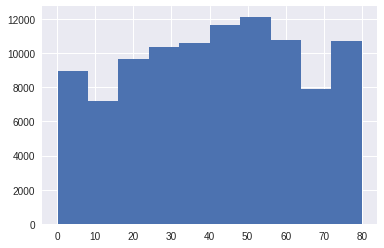

In [0]:
plt.hist(data['age'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.6570e+03, 3.1394e+04, 2.4929e+04, 7.3890e+03, 1.7160e+03,
        3.7900e+02, 7.3000e+01, 8.0000e+00, 4.0000e+00, 7.0000e+00]),
 array([10.01 , 18.578, 27.146, 35.714, 44.282, 52.85 , 61.418, 69.986,
        78.554, 87.122, 95.69 ]),
 <a list of 10 Patch objects>)

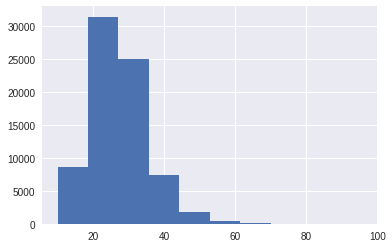

In [0]:
plt.hist(data['BMI'])

In [0]:
data_complete_df['hypertension'].value_counts()

0.0    92515
1.0     7485
Name: hypertension, dtype: int64

# ** Splitting**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data_complete_df.drop(['hypertension'], axis= 1), 
                                                    data_complete_df['hypertension'], test_size=0.3, random_state=11)

In [0]:
print("Number of Employees in X_train dataset: ", x_train.shape)
print("Number of Employees in y_train dataset: ", y_train.shape)
print("Number of Employees in X_test dataset: ", x_test.shape)
print("Number of Employees in y_test dataset: ", y_test.shape)

Number of Employees in X_train dataset:  (70000, 22)
Number of Employees in y_train dataset:  (70000,)
Number of Employees in X_test dataset:  (30000, 22)
Number of Employees in y_test dataset:  (30000,)


#** Without interaction variables **

In [0]:
ndata=data_complete_df.drop(['diabetes & hypertension','diabetes & srtoke','diabetes & heart disease','hypertension & stroke','hypertension & heart disease','stroke & heart disease',
                            'diabetes,hypertension,stroke','diabetes,hypertension,heart disease','hypertension,stroke,heart disease'],axis=1)

In [0]:
ndata.shape

(100000, 13)

In [0]:
xx_train, xx_test, yy_train, yy_test = train_test_split(ndata.drop(['hypertension'], axis= 1), 
                                                    ndata['hypertension'], test_size=0.3, random_state=123)

In [0]:
Dt_w=DecisionTreeClassifier()
Rf_w=RandomForestClassifier()
Bagg_w=BaggingClassifier(base_estimator=Dt_w)
Boost_w=AdaBoostClassifier(base_estimator=Dt_w)
Knn_w=KNeighborsClassifier()
Svc_w=LinearSVC()
Lr_w=LogisticRegression()
Gbc_w=GradientBoostingClassifier()
Xgb_w=XGBClassifier()
Gnb_w=GaussianNB()
Bnb_w=BernoulliNB()

In [0]:
models=[Rf_w,Boost_w,Bagg_w,Svc_w,Knn_w,Dt_w,Lr_w,Gbc_w,Xgb_w,Gnb_w,Bnb_w]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores1 = []
F1_score1=[]
mcc1=[]

d={}

for model in range(len(models)):
    m = models[model]
    m.fit(xx_train, yy_train)
    test_pred_w = m.predict(xx_test)
    ROC_AUC_scores1.append(roc_auc_score(yy_test, test_pred_w))
    F1_score1.append(f1_score(yy_test,test_pred_w))
    #ck.append(cohen_kappa_score(y_test,test_pred))
    mcc1.append(matthews_corrcoef(yy_test,test_pred_w))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores1,'F1_Score':F1_score1,'MCC':mcc1}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.141686,0.100367,RandomForestClassifier,0.537256
1,0.145414,0.096307,AdaBoostClassifier,0.538712
2,0.129894,0.096582,BaggingClassifier,0.532832
3,0.011586,0.073457,LinearSVC,0.502913
4,0.078067,0.073351,KNeighborsClassifier,0.517158
5,0.184422,0.116703,DecisionTreeClassifier,0.560084
6,0.033693,0.078751,LogisticRegression,0.507930
7,0.013357,0.078909,GradientBoostingClassifier,0.503362
8,0.011586,0.073457,XGBClassifier,0.502913
9,0.269069,0.204907,GaussianNB,0.612937


# ** Models on upsampled data**

In [0]:
sm=SMOTE(random_state=123)

In [0]:
X_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

In [0]:
print("Before OvererSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))


Before OvererSampling, counts of label '1': 5230
Before OverSampling, counts of label '0': 64770 



In [0]:
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

After OverSampling, the shape of X_train: (129540, 21)
After OverSampling, the shape of y_train: (129540,) 



In [0]:
print("After OvererSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))


After OvererSampling, counts of label '1': 64770
After OverSampling, counts of label '0': 64770 



In [0]:
Dt=DecisionTreeClassifier()
Rf=RandomForestClassifier()
Bagg=BaggingClassifier(base_estimator=Dt)
Boost=AdaBoostClassifier(base_estimator=Dt)
Knn=KNeighborsClassifier()
Svc=LinearSVC()
Lr=LogisticRegression()
Gbc=GradientBoostingClassifier()
Xgb=XGBClassifier()
Gnb=GaussianNB()
Bnb=BernoulliNB()

In [0]:
models=[Rf,Boost,Bagg,Svc,Knn,Dt,Lr,Gbc,Xgb,Gnb,Bnb]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores = []
F1_score=[]
mcc=[]

d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train_res, y_train_res)
    test_pred = clf.predict(x_test.as_matrix())
    ROC_AUC_scores.append(roc_auc_score(y_test, test_pred))
    F1_score.append(f1_score(y_test,test_pred))
    mcc.append(matthews_corrcoef(y_test,test_pred))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores,'F1_Score':F1_score,'MCC':mcc}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.437086,0.388687,RandomForestClassifier,0.711927
1,0.416035,0.366067,AdaBoostClassifier,0.713048
2,0.437049,0.388641,BaggingClassifier,0.712076
3,0.268405,0.284165,LinearSVC,0.768657
4,0.316960,0.264822,KNeighborsClassifier,0.691505
5,0.409025,0.358553,DecisionTreeClassifier,0.711073
6,0.366861,0.355175,LogisticRegression,0.789404
7,0.417144,0.381949,GradientBoostingClassifier,0.763759
8,0.387725,0.361195,XGBClassifier,0.771541
9,0.487973,0.482621,GaussianNB,0.681975


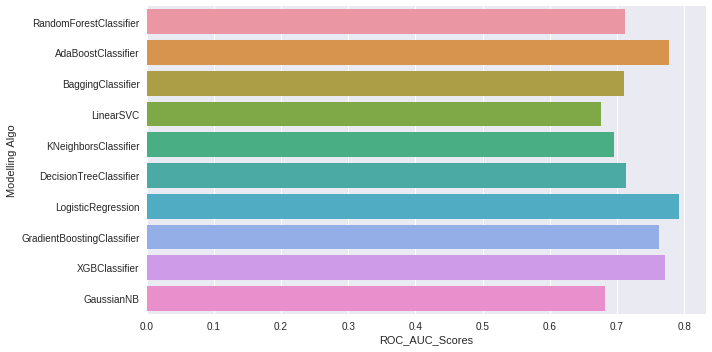

In [0]:
import seaborn as sns
sns.factorplot(y='Modelling Algo', x='ROC_AUC_Scores', data= df_models, kind = 'bar', size=5, aspect=2)

# ** Under Sampling**

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
xx=x_train.values
yy=y_train.values
xx_testt=x_test.values
yy_testt=y_test.values

In [0]:
x_train.head()

,gender_Male,gender_Other,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,stroke,heart disease,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","diabetes,hypertension,stroke,heart disease"
41446,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83682,1.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10698,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11748,0.0,0.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30672,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
rus=RandomUnderSampler(return_indices=True)
X_rus,y_rus,id_rus=rus.fit_sample(xx,yy)

In [0]:
X_rus.shape

(10460, 21)

In [0]:
xxx=pd.DataFrame(X_rus)

xxx.columns=x_train.columns
xxx.head()

,gender_Male,gender_Other,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,stroke,heart disease,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","diabetes,hypertension,stroke,heart disease"
0,0.0,0.0,0.0,0.0,0.0,1.0,44.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,56.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,47.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
yyy=pd.DataFrame(y_rus,columns=['hypertension'])
yyy.head()


,hypertension
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [0]:
yyy['hypertension'].value_counts()

1.0    5230
0.0    5230
Name: hypertension, dtype: int64

In [0]:
Dt_us=DecisionTreeClassifier()
Rf_us=RandomForestClassifier()
Bagg_us=BaggingClassifier(base_estimator=Dt_us)
Boost_us=AdaBoostClassifier(base_estimator=Dt_us)
Knn_us=KNeighborsClassifier()
Svc_us=LinearSVC()
Lr_us=LogisticRegression()
Gbc_us=GradientBoostingClassifier()
Xgb_us=XGBClassifier()
Gnb_us=GaussianNB()
Bnb_us=BernoulliNB()

In [0]:
models=[Rf_us,Boost_us,Bagg_us,Svc_us,Knn_us,Dt_us,Lr_us,Gbc_us,Xgb_us,Gnb_us,Bnb_us,]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores1 = []
F1_score1=[]
mcc1=[]

d={}

for model in range(len(models)):
    m = models[model]
    m.fit(xxx,yyy)
    test_pred_us = m.predict(x_test)
    ROC_AUC_scores1.append(roc_auc_score(y_test, test_pred_us))
    F1_score1.append(f1_score(y_test,test_pred_us))
    #ck.append(cohen_kappa_score(y_test,test_pred))
    mcc1.append(matthews_corrcoef(y_test,test_pred_us))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores1,'F1_Score':F1_score1,'MCC':mcc1}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.330160,0.307091,RandomForestClassifier,0.753490
1,0.302359,0.282033,AdaBoostClassifier,0.744602
2,0.332520,0.309955,BaggingClassifier,0.755409
3,0.356328,0.347656,LinearSVC,0.789426
4,0.269509,0.241642,KNeighborsClassifier,0.716202
5,0.301048,0.279640,DecisionTreeClassifier,0.742284
6,0.364877,0.353683,LogisticRegression,0.789311
7,0.333937,0.336818,GradientBoostingClassifier,0.795707
8,0.330130,0.331790,XGBClassifier,0.791863
9,0.487973,0.482621,GaussianNB,0.681975


# **Models on imbalanced dataset**

In [0]:
Dt_ib=DecisionTreeClassifier()
Rf_ib=RandomForestClassifier()
Bagg_ib=BaggingClassifier(base_estimator=Dt_ib)
Boost_ib=AdaBoostClassifier(base_estimator=Dt_ib)
Knn_ib=KNeighborsClassifier()
Svc_ib=LinearSVC()
Lr_ib=LogisticRegression()
Gbc_ib=GradientBoostingClassifier()
Xgb_ib=XGBClassifier()
Gnb_ib=GaussianNB()
Bnb_ib=BernoulliNB()

In [0]:
models=[Rf_ib,Boost_ib,Bagg_ib,Svc_ib,Knn_ib,Dt_ib,Lr_ib,Gbc_ib,Xgb_ib,Gnb_ib,Bnb_ib]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores = []
F1_score=[]
mcc=[]

d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_train)
    test_pred_ib= clf.predict(x_test)
    ROC_AUC_scores.append(roc_auc_score(y_test, test_pred_ib))
    F1_score.append(f1_score(y_test,test_pred_ib))
    mcc.append(matthews_corrcoef(y_test,test_pred_ib))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores,'F1_Score':F1_score,'MCC':mcc}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.500130,0.475572,RandomForestClassifier,0.701447
1,0.459480,0.429395,AdaBoostClassifier,0.684687
2,0.514223,0.502329,BaggingClassifier,0.698591
3,0.548439,0.599701,LinearSVC,0.688914
4,0.288936,0.335362,KNeighborsClassifier,0.587791
5,0.457890,0.413809,DecisionTreeClassifier,0.706989
6,0.548086,0.598904,LogisticRegression,0.688877
7,0.548439,0.599701,GradientBoostingClassifier,0.688914
8,0.547972,0.599338,XGBClassifier,0.688692
9,0.487973,0.482621,GaussianNB,0.681975


In [0]:
Xgb_ib.fit(X=x_train,y=y_train)
test_pred_ib=Xgb_ib.predict(x_test)

In [0]:
print('ROC_AUC Score:',roc_auc_score(y_test, test_pred_ib))
print('F1_score',f1_score(y_test,test_pred_ib))
print('MCC Score',matthews_corrcoef(y_test,test_pred_ib))

ROC_AUC Score: 0.6886917960088692
F1_score 0.5479716677398583
MCC Score 0.5993383134427629


# Neural Network

In [0]:
from keras.layers import Dense,Input,BatchNormalization,Dropout
from keras.models import Model,K, Sequential
from keras.optimizers import SGD, rmsprop

In [0]:
K.clear_session()
def build_model():
  classifier = Sequential()
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=1,input_dim=22,init='uniform',activation='sigmoid'))
  classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=[auc])
  return classifier

In [0]:
import tensorflow as tf
from keras import backend as K

def auc(y_test,y_pred_keras):
    auc = tf.metrics.auc(y_test, y_pred_keras)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(x_train, y_train, epochs=100, batch_size=100,verbose=1,validation_split=0.3)

Train on 49000 samples, validate on 21000 samples
Epoch 1/100
49000/49000 [==============================] - 4s 91us/step - loss: 0.3429 - auc: 0.4291 - val_loss: 0.2518 - val_auc: 0.5016
Epoch 2/100
49000/49000 [==============================] - 4s 80us/step - loss: 0.2442 - auc: 0.5782 - val_loss: 0.2325 - val_auc: 0.6224
Epoch 3/100
49000/49000 [==============================] - 4s 82us/step - loss: 0.2310 - auc: 0.6521 - val_loss: 0.2168 - val_auc: 0.6761
Epoch 4/100
49000/49000 [==============================] - 4s 82us/step - loss: 0.2086 - auc: 0.6950 - val_loss: 0.1907 - val_auc: 0.7122
Epoch 5/100
49000/49000 [==============================] - 4s 81us/step - loss: 0.1860 - auc: 0.7290 - val_loss: 0.1748 - val_auc: 0.7468
Epoch 6/100
49000/49000 [==============================] - 4s 81us/step - loss: 0.1811 - auc: 0.7607 - val_loss: 0.1673 - val_auc: 0.7724
Epoch 7/100
49000/49000 [==============================] - 4s 81us/step - loss: 0.1762 - auc: 0.7825 - val_loss: 0.1648 - 

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
print('ROC_AUC Score:',roc_auc_score(y_test, y_pred_keras))
print('F1_score',f1_score(y_test,y_pred_keras.round()))
print('MCC Score',matthews_corrcoef(y_test,y_pred_keras.round()))
#accuracy_score(y_true, y_pred.round(), normalize=False)

ROC_AUC Score: 0.895174720360713
F1_score 0.5484390086900547
MCC Score 0.5997006346261777


In [0]:
print(classification_report(y_test,y_pred_keras.round()))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     27745
         1.0       1.00      0.38      0.55      2255

   micro avg       0.95      0.95      0.95     30000
   macro avg       0.98      0.69      0.76     30000
weighted avg       0.96      0.95      0.94     30000



In [0]:
auc_keras = auc(fpr_keras, tpr_keras)

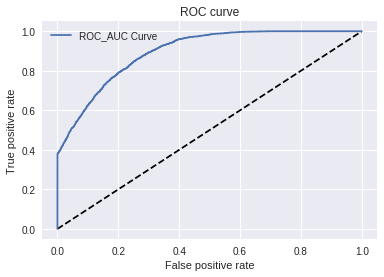

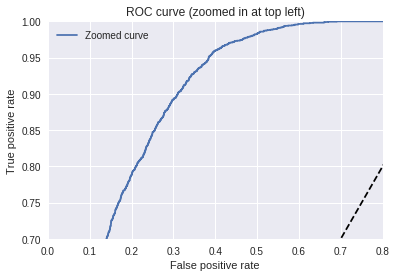

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,label='ROC_AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.8)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,label='Zoomed curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Tuning

In [0]:
param_grid_Lr_ib={"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_Boost_ib={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005]}
param_grid_Xgb_ib={'n_estimators':[50,100,200],'learning_rate':[0.01,0.05,0.1],'max_depth':[3,5,7,9]}
param_grid_Gbc_ib={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005],'max_depth': [4, 6, 8,10]}
param_grid_Bagg_ib={'n_estimators':[50,100,200]}
param_grid_Rf_ib={'n_estimators':[50,100,200],'max_depth':[3,5,7,9]}

In [0]:
best_model_Lr_ib = GridSearchCV(estimator=Lr_ib,param_grid=param_grid_Lr_ib,scoring='f1',n_jobs=-1,cv=5)
best_model_Boost_ib = GridSearchCV(estimator=Boost_ib,param_grid=param_grid_Boost_ib ,scoring='f1',n_jobs=-1,cv=5)
best_model_Xgb_ib = GridSearchCV(estimator=Xgb_ib,param_grid=param_grid_Xgb_ib ,scoring='f1',n_jobs=-1,cv=5)
best_model_Gbc_ib = GridSearchCV(estimator=Gbc_ib,param_grid=param_grid_Gbc_ib ,scoring='f1',n_jobs=-1,cv=5)
best_model_Bagg_ib = GridSearchCV(estimator=Bagg_ib,param_grid=param_grid_Bagg_ib ,scoring='f1',n_jobs=-1,cv=5)
best_model_Rf_ib = GridSearchCV(estimator=Rf_ib,param_grid=param_grid_Rf_ib ,scoring='f1',n_jobs=-1,cv=5)

Logistic Regression

In [0]:
best_model_Lr_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Lr_ib.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [0]:
#cross_val_score(best_model_Lr_ib.best_estimator_,X=X_train_res,y=y_train_res,cv=5)

In [0]:
test_pred_lr = best_model_Lr_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_lr))
print('F1_score:', f1_score(y_test,test_pred_lr))

ROC_AUC Score: 0.6888774829687058
F1_score: 0.5480862013509167


AdaBoost

In [0]:
best_model_Boost_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.0001, 0.0003, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Boost_ib.best_params_

{'learning_rate': 0.0005, 'n_estimators': 200}

In [0]:
test_pred_Boost = best_model_Boost_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_Boost))
print('F1_score:', f1_score(y_test,test_pred_Boost))

ROC_AUC Score: 0.7083488005869099
F1_score: 0.47048054919908466


In [0]:
#cross_val_score(best_model_Boost.best_estimator_,X=X_train_res,y=y_train_res,cv=5)

array([0.9772859 , 0.98902333, 0.98840664, 0.98942106, 0.98963843])

XGBoost

In [0]:
best_model_Xgb_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Xgb_ib .best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [0]:
test_pred_Xgb = best_model_Xgb_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_Xgb))
print('F1_score:', f1_score(y_test,test_pred_Xgb))

ROC_AUC Score: 0.6888955042337985
F1_score: 0.5482625482625482


Gradient Boosting Classifier

In [0]:
best_model_Gbc_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.0001, 0.0003, 0.0005], 'max_depth': [4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Gbc_ib .best_params_

{'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 50}

In [0]:
test_pred_Gbc = best_model_Gbc_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_Gbc))
print('F1_score:', f1_score(y_test,test_pred_Gbc))
print('F1_score:', classification_report(y_test,test_pred_Gbc))

ROC_AUC Score: 0.5
F1_score: 0.0
F1_score:               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     27745
         1.0       0.00      0.00      0.00      2255

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.46      0.50      0.48     30000
weighted avg       0.86      0.92      0.89     30000



Bagging Classifier

In [0]:
best_model_Bagg_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Bagg_ib .best_params_

{'n_estimators': 100}

In [0]:
test_pred_Bagg = best_model_Bagg_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_Bagg))
print('F1_score:', f1_score(y_test,test_pred_Bagg))

ROC_AUC Score: 0.6995318866506379
F1_score: 0.5162893429044727


Random Forest

In [0]:
best_model_Rf_ib.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_Rf_ib.best_params_

{'max_depth': 5, 'n_estimators': 50}

In [0]:
test_pred_Rf = best_model_Rf_ib.predict(x_test)
print('ROC_AUC Score:', roc_auc_score(y_test, test_pred_Rf))
print('F1_score:', f1_score(y_test,test_pred_Rf))

ROC_AUC Score: 0.6880266075388026
F1_score: 0.5465678375765388


In [0]:
#c=cross_val_score(best_model_tree.best_estimator_,X=X_train_res,y=y_train_res,cv=5).mean()
#c

# Voting Classifier

In [0]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('Random Forest', best_model_Rf_ib), ('Adaboost', best_model_Boost_ib),('Bagging', best_model_Bagg_ib),('SVC', Svc_ib),('Logistic Regression', best_model_Lr_ib),('Gradient Bosting', Gbc_ib), ('XGBoost', best_model_Xgb_ib),('GaussianNB', Gnb_ib),('BernoulliNB',Bnb_ib)], voting='hard')
model.fit(x_train, y_train)
test_m_pred=model.predict(x_test)
#model.score(x_test,test_m_pred)
print('ROC_AUC Score:',roc_auc_score(y_test, test_m_pred))
print('F1_score',f1_score(y_test,test_m_pred))

ROC_AUC Score: 0.6889135254988914
F1_score 0.5484390086900547


# ** Data to csv **

In [0]:
data_complete_df.to_excel(r'C:\Users\user\Desktop\BA\Term-III\Capstone Project\New_data.xlsx')

In [0]:
from google.colab import files